# Graphs
> Embedding and classifying graphs with hyperbolic decision trees

Based on https://geomstats.github.io/notebooks/13_real_world_applications__graph_embedding_and_clustering_in_hyperbolic_space.html#

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install geomstats
!pip install networkx
!pip install torch
!pip install torch_geometric

In [3]:
import logging

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall


INFO: Using numpy backend


In [4]:
# Hyperparameters and data loading

gs.random.seed(1234)
dim = 2
max_epochs = 100
lr = 0.05
n_negative = 2
context_size = 1
karate_graph = load_karate_graph()


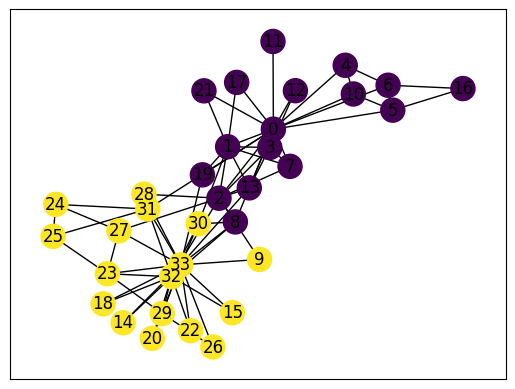

In [5]:
# Convert geomstats graph to networkx graph; visualize

karate_graph_nx = nx.Graph()
nodes = []
edges = []
for key in karate_graph.edges:
    nodes.append(key)
    for edge in karate_graph.edges[key]:
        edges.append([key, edge])
karate_graph_nx.add_nodes_from(nodes)
karate_graph_nx.add_edges_from(edges)

nx.draw_networkx(
    karate_graph_nx,
    with_labels=True,
    node_color=[karate_graph.labels[x][0] for x in nodes],
)


In [6]:
# Embed

hyperbolic_manifold = PoincareBall(2)


def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    log_map = PoincareBall(2).metric.log(point_b, point_a)

    return -2 * log_map


def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))


def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))


def loss(example_embedding, context_embedding, negative_embedding, manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim = negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance = manifold.metric.squared_dist(
        example_embedding, context_embedding
    )
    positive_loss = log_sigmoid(-positive_distance)

    reshaped_example_embedding = gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance = manifold.metric.squared_dist(
        reshaped_example_embedding, negative_embedding
    )
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad = -grad_log_sigmoid(-positive_distance)

    positive_distance_grad = grad_squared_distance(
        example_embedding, context_embedding
    )

    positive_grad = (
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)
        * positive_distance_grad
    )

    negative_distance_grad = grad_squared_distance(
        reshaped_example_embedding, negative_embedding
    )

    negative_distance = gs.to_ndarray(negative_distance, to_ndim=2, axis=-1)
    negative_log_sigmoid_grad = grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad


# Embed


def embed_graph(graph):
    nb_vertices_by_edges = [len(e_2) for _, e_2 in graph.edges.items()]

    embeddings = gs.random.normal(size=(graph.n_nodes, dim))
    embeddings = embeddings * 0.2
    random_walks = graph.random_walk()
    negative_table_parameter = 5
    negative_sampling_table = []

    for i, nb_v in enumerate(nb_vertices_by_edges):
        negative_sampling_table += (
            [i] * int((nb_v ** (3.0 / 4.0))) * negative_table_parameter
        )

    negative_sampling_table = gs.array(negative_sampling_table)

    for epoch in range(max_epochs):
        total_loss = []
        for path in random_walks:

            for example_index, one_path in enumerate(path):
                context_index = path[
                    max(0, example_index - context_size) : min(
                        example_index + context_size, len(path)
                    )
                ]
                negative_index = gs.random.randint(
                    negative_sampling_table.shape[0],
                    size=(len(context_index), n_negative),
                )
                negative_index = negative_sampling_table[negative_index]

                example_embedding = embeddings[one_path]
                for one_context_i, one_negative_i in zip(
                    context_index, negative_index
                ):
                    context_embedding = embeddings[one_context_i]
                    negative_embedding = embeddings[one_negative_i]
                    l, g_ex = loss(
                        example_embedding,
                        context_embedding,
                        negative_embedding,
                        hyperbolic_manifold,
                    )
                    total_loss.append(l)

                    example_to_update = embeddings[one_path]
                    embeddings[one_path] = hyperbolic_manifold.metric.exp(
                        -lr * g_ex, example_to_update
                    )
        logging.info(
            "iteration %d loss_value %f",
            epoch,
            sum(total_loss, 0) / len(total_loss),
        )

    return embeddings


embeddings = embed_graph(karate_graph)


INFO: iteration 0 loss_value 1.828136
INFO: iteration 1 loss_value 1.724163
INFO: iteration 2 loss_value 1.674264
INFO: iteration 3 loss_value 1.548667
INFO: iteration 4 loss_value 1.512775
INFO: iteration 5 loss_value 1.445264
INFO: iteration 6 loss_value 1.430681
INFO: iteration 7 loss_value 1.376823
INFO: iteration 8 loss_value 1.347691
INFO: iteration 9 loss_value 1.354174
INFO: iteration 10 loss_value 1.366510
INFO: iteration 11 loss_value 1.340743
INFO: iteration 12 loss_value 1.314952
INFO: iteration 13 loss_value 1.294744
INFO: iteration 14 loss_value 1.288353
INFO: iteration 15 loss_value 1.262640
INFO: iteration 16 loss_value 1.292248
INFO: iteration 17 loss_value 1.305154
INFO: iteration 18 loss_value 1.306525
INFO: iteration 19 loss_value 1.263639
INFO: iteration 20 loss_value 1.299607
INFO: iteration 21 loss_value 1.263204
INFO: iteration 22 loss_value 1.271372
INFO: iteration 23 loss_value 1.300537
INFO: iteration 24 loss_value 1.300886
INFO: iteration 25 loss_value 1.266

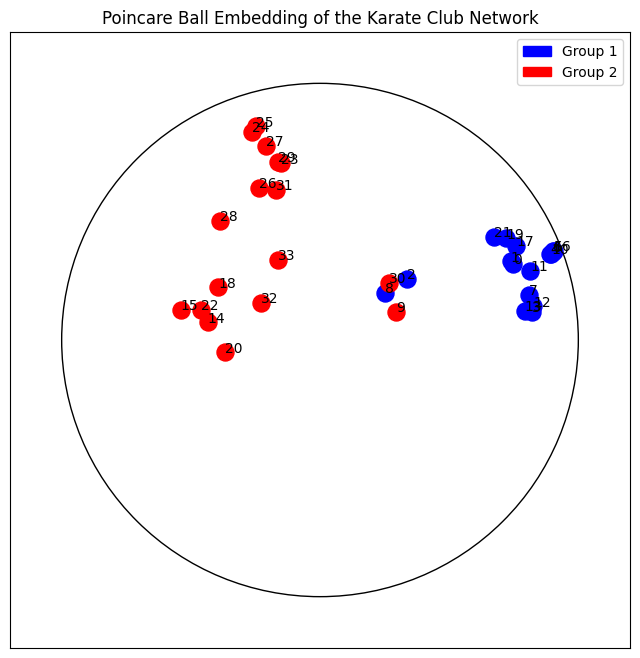

In [7]:
import matplotlib.patches as mpatches


def plot_graph(embeddings):
    colors = {1: "b", 2: "r"}
    group_1 = mpatches.Patch(color=colors[1], label="Group 1")
    group_2 = mpatches.Patch(color=colors[2], label="Group 2")

    circle = visualization.PoincareDisk(coords_type="ball")

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    circle.set_ax(ax)
    circle.draw(ax=ax)
    for i_embedding, embedding in enumerate(embeddings):
        x = embedding[0]
        y = embedding[1]
        pt_id = i_embedding
        plt.scatter(x, y, c=colors[karate_graph.labels[pt_id][0]], s=150)
        ax.annotate(pt_id, (x, y))

    plt.tick_params(which="both")
    plt.title("Poincare Ball Embedding of the Karate Club Network")
    plt.legend(handles=[group_1, group_2])
    plt.show()


plot_graph(embeddings)


INFO: iteration 0 loss_value 1.807967
INFO: iteration 1 loss_value 1.762672
INFO: iteration 2 loss_value 1.659758
INFO: iteration 3 loss_value 1.605007
INFO: iteration 4 loss_value 1.507695
INFO: iteration 5 loss_value 1.523809
INFO: iteration 6 loss_value 1.454528
INFO: iteration 7 loss_value 1.395240
INFO: iteration 8 loss_value 1.366260
INFO: iteration 9 loss_value 1.439076
INFO: iteration 10 loss_value 1.349570
INFO: iteration 11 loss_value 1.332939
INFO: iteration 12 loss_value 1.370132
INFO: iteration 13 loss_value 1.261428
INFO: iteration 14 loss_value 1.350017
INFO: iteration 15 loss_value 1.313022
INFO: iteration 16 loss_value 1.289277
INFO: iteration 17 loss_value 1.282588
INFO: iteration 18 loss_value 1.260400
INFO: iteration 19 loss_value 1.272612
INFO: iteration 20 loss_value 1.323300
INFO: iteration 21 loss_value 1.282165
INFO: iteration 22 loss_value 1.287407
INFO: iteration 23 loss_value 1.286936
INFO: iteration 24 loss_value 1.274754
INFO: iteration 25 loss_value 1.305

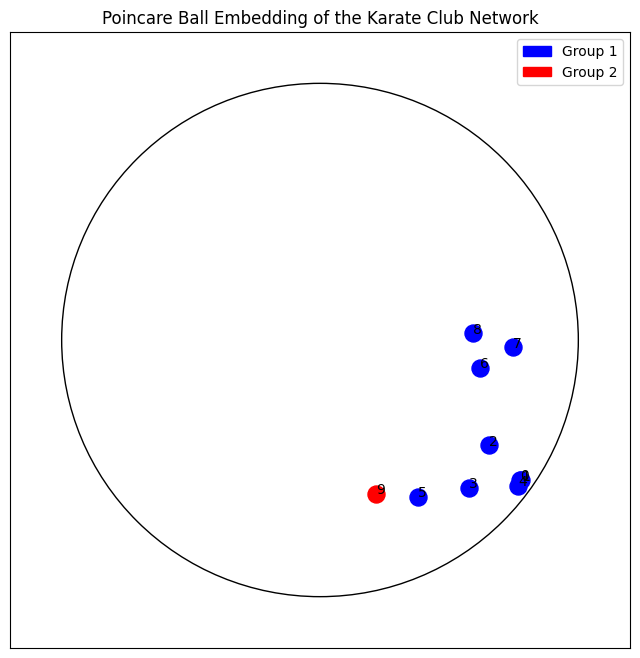

In [8]:
# Now try this with another dataset

from geomstats.datasets.utils import load_random_graph

randg = load_random_graph()
randg_embedding = embed_graph(randg)
plot_graph(randg_embedding)


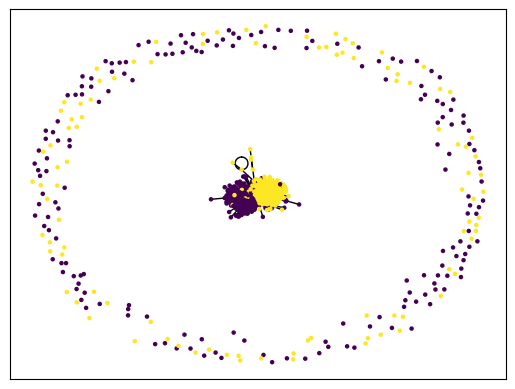

In [57]:
# # Embed polblogs


# def load_polblogs(path):
#     with open(path, "r") as f:
#         lines = f.readlines()
#     lines = lines[2:]
#     edges = []
#     for line in lines:
#         in_id, out_id, num_edges = line.split(" ")
#         for i in range(int(num_edges)):
#             edges.append([int(in_id) - 1, int(out_id) - 1])
#     edges = np.array(edges)
#     n_nodes = np.max(edges) + 1
#     graph = nx.Graph()
#     graph.add_nodes_from(range(n_nodes))
#     graph.add_edges_from(edges)
#     return graph

# polblogs_graph = load_polblogs(polblogs_path)

# nx.draw_networkx(polblogs_graph, with_labels=False, node_size=5)
import pandas as pd

adjacency = pd.read_table(
    "data/polblogs/raw/adjacency.tsv", header=None, usecols=[0, 1]
)
names = pd.read_table("data/polblogs/raw/names.tsv", header=None)
labels = pd.read_table("data/polblogs/raw/labels.tsv", header=None)
names_labels = pd.read_table("data/polblogs/raw/names_labels.tsv", header=None)

polblogs_graph = nx.from_pandas_edgelist(adjacency, source=0, target=1)
polblogs_graph.add_nodes_from(names.index)

nx.draw_networkx(
    polblogs_graph,
    with_labels=False,
    node_size=5,
    node_color=labels[0].reindex(polblogs_graph.nodes),  # Ordering
)


In [89]:
# Convert to geomstats graph

from geomstats.datasets.prepare_graph_data import Graph, HyperbolicEmbedding


def nx_to_geomstats(graph, labels, drop_isolated=True):
    out_graph = load_karate_graph()  # Need a starter graph
    out_graph.n_nodes = graph.number_of_nodes()
    out_graph.n_edges = graph.number_of_edges()
    out_graph.edges = {
        node: list(graph.neighbors(node)) for node in graph.nodes
    }
    out_graph.labels = labels[0].reindex(polblogs_graph.nodes)

    if drop_isolated:
        for node in reversed(list(out_graph.edges.keys())):
            if len(out_graph.edges[node]) == 0:
                # del out_graph.edges[node]
                # del out_graph.labels[node]
                # out_graph.n_nodes -= 1
                # Add self-edge instead
                out_graph.edges[node] = [node]

    return out_graph


polblogs_graph_geom = nx_to_geomstats(polblogs_graph, labels)


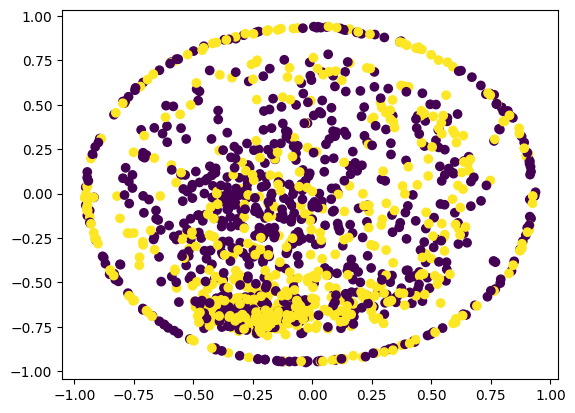

In [92]:
# Embed

hyp_emb = HyperbolicEmbedding()
polblogs_graph_embedded = hyp_emb.embed(polblogs_graph_geom)

plt.scatter(
    polblogs_graph_embedded[:, 0],
    polblogs_graph_embedded[:, 1],
    c=polblogs_graph_geom.labels,
)


In [101]:
# Convert to hyperboloid


def to_hyperboloid_points(poincare_pts):
    """
    Post: result.shape[1] == poincare_pts.shape[1] + 1
    """
    norm_sqd = (poincare_pts ** 2).sum(axis=1)
    N = poincare_pts.shape[1]
    result = np.zeros((poincare_pts.shape[0], N + 1), dtype=np.float64)
    result[:, :N] = (2.0 / (1 - norm_sqd))[:, np.newaxis] * poincare_pts
    result[:, N] = (1 + norm_sqd) / (1 - norm_sqd)
    return result


to_hyperboloid_points(polblogs_graph_embedded).shape


(1490, 3)

In [108]:
# Try classifying hyp_emb now

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from src.tree import HyperbolicDecisionTreeClassifier
from src.forest import HyperbolicRandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    to_hyperboloid_points(polblogs_graph_embedded),
    np.array(polblogs_graph_geom.labels),
    test_size=0.2,
    random_state=42,
)

# Hyperparameters
MIN_SAMPLES = 2
MAX_DEPTH = 10
args = dict(min_samples=MIN_SAMPLES, max_depth=MAX_DEPTH)

# Fit a regular decision tree
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

# Fit a hyperbolic decision tree
hdt = HyperbolicDecisionTreeClassifier(**args)
hdt.fit(X_train, y_train)

# Control dt
hdt_control = HyperbolicDecisionTreeClassifier(hyperbolic=False, **args)
hdt_control.fit(X_train, y_train)

# Sklearn random forest
rf = RandomForestClassifier(n_estimators=1000, max_depth=4)
rf.fit(X_train, y_train)

# Hyperbolic random forest
hrf = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=True, **args
)
hrf.fit(X_train, y_train)

# Control hrf
hrf_control = HyperbolicRandomForestClassifier(
    n_estimators=1000, hyperbolic=False, **args
)
hrf_control.fit(X_train, y_train)

# Compare scores
print(
    f"Regular decision tree accuracy: {accuracy_score(y_test, dt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy: {accuracy_score(y_test, hdt.predict(X_test)):.3f}",
    f"Hyperbolic decision tree accuracy (control): {accuracy_score(y_test, hdt_control.predict(X_test)):.3f}",
    "",
    f"Random forest accuracy: {accuracy_score(y_test, rf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy: {accuracy_score(y_test, hrf.predict(X_test)):.3f}",
    f"Hyperbolic random forest accuracy (control): {accuracy_score(y_test, hrf_control.predict(X_test)):.3f}",
    sep="\n",
)


Regular decision tree accuracy: 0.631
Hyperbolic decision tree accuracy: 0.631
Hyperbolic decision tree accuracy (control): 0.597

Random forest accuracy: 0.661
Hyperbolic random forest accuracy: 0.611
Hyperbolic random forest accuracy (control): 0.607
